## 1. Installation and Imports

In [9]:
# Install LiVAE if not already installed
# !pip install livae

# Add parent directory to path for development
import sys
from pathlib import Path
sys.path.insert(0, str(Path().absolute().parent))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad

# Import LiVAE
from livae import agent

# Set random seed for reproducibility
np.random.seed(42)

print(f"LiVAE imported successfully!")
print(f"Available in livae: {dir(agent)}")

LiVAE imported successfully!
Available in livae: ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_betatc_compute_gaussian_log_density', '_betatc_compute_total_correlation', '_calc_corr', '_calc_label', '_calc_score', '_compute_kernel', '_compute_mmd', '_compute_unbiased_mean', '_dip_cov_matrix', '_dip_loss', '_kernel_rbf', '_log_nb', '_metrics', '_normal_kl', '_register_anndata', '_sample_data', 'fit', 'get_iembed', 'get_latent', 'load_data', 'step', 'take_latent', 'update']


## 2. Create Synthetic Single-Cell Data

We'll generate a synthetic dataset that mimics real single-cell RNA-seq data with distinct cell populations:

**Dataset specifications:**
- **500 cells**: 200 Type A + 150 Type B + 150 Type C
- **100 genes**: Sufficient features for demonstrating embedding
- **3 cell types** with characteristic expression signatures:
  - **Type A**: High expression in genes 0-30 (early markers)
  - **Type B**: High expression in genes 30-60 (intermediate markers)
  - **Type C**: High expression in genes 60-90 (late markers)
  
**Expression pattern:**
- Background expression: Poisson(λ=5.0) across all genes
- Cell-type markers: Poisson(λ=15.0) in signature regions (3× higher)

This design creates clear separation between cell types while maintaining realistic count-based variability.

In [10]:
# Create synthetic single-cell data with distinct cell type signatures
n_cells = 500
n_genes = 100

# Define cell populations: 200 Type A, 150 Type B, 150 Type C
cell_types = ['Type_A'] * 200 + ['Type_B'] * 150 + ['Type_C'] * 150

# Generate count data with cell-type-specific expression patterns
# Background expression: Poisson(λ=5.0) for all genes
# Marker genes: Poisson(λ=15.0) in cell-type-specific regions (3× higher)

# Type A: High expression in genes 0-30 (early markers)
data_A = np.random.poisson(5.0, (200, n_genes))
data_A[:, :30] = np.random.poisson(15.0, (200, 30))

# Type B: High expression in genes 30-60 (intermediate markers)
data_B = np.random.poisson(5.0, (150, n_genes))
data_B[:, 30:60] = np.random.poisson(15.0, (150, 30))

# Type C: High expression in genes 60-90 (late markers)
data_C = np.random.poisson(5.0, (150, n_genes))
data_C[:, 60:90] = np.random.poisson(15.0, (150, 30))

# Combine all cell types
X = np.vstack([data_A, data_B, data_C]).astype(float)

# Create AnnData object with metadata
adata = ad.AnnData(X)
adata.obs['cell_type'] = cell_types
adata.layers['counts'] = X.copy()
adata.var_names = [f'Gene_{i}' for i in range(n_genes)]

print(f"Created AnnData object:")
print(f"  Shape: {adata.shape}")
print(f"  Cell types: {adata.obs['cell_type'].value_counts().to_dict()}")
print(f"  Layers: {list(adata.layers.keys())}")

Created AnnData object:
  Shape: (500, 100)
  Cell types: {'Type_A': 200, 'Type_B': 150, 'Type_C': 150}
  Layers: ['counts']


## 3. Visualize Input Data

Before training, let's verify our synthetic data has the expected expression patterns. Each cell type should show elevated expression in its characteristic gene region, with low background elsewhere.

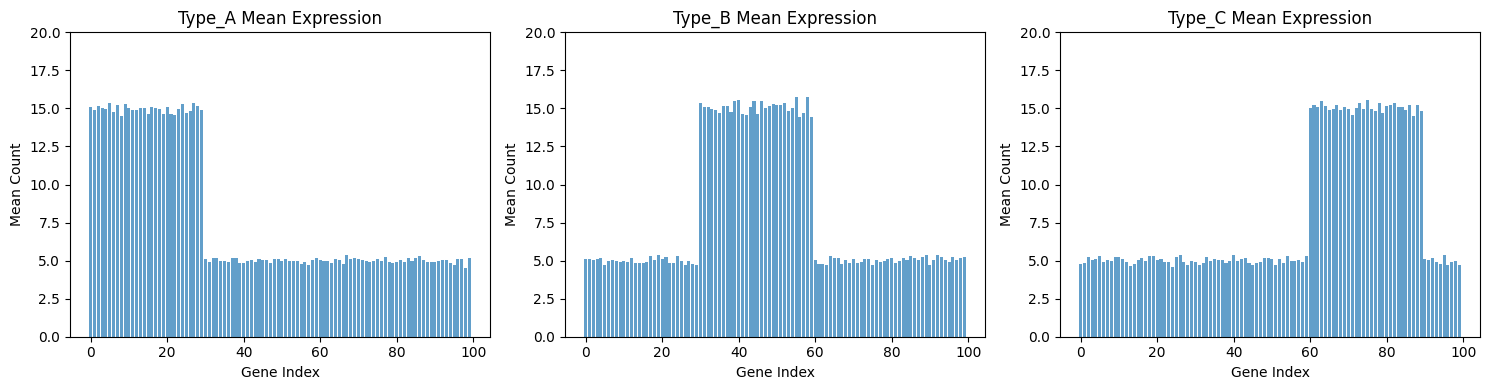

Each cell type has distinct expression patterns in different gene regions.


In [11]:
# Visualize the expression patterns
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, cell_type in enumerate(['Type_A', 'Type_B', 'Type_C']):
    mask = adata.obs['cell_type'] == cell_type
    mean_expr = adata.X[mask].mean(axis=0)
    axes[i].bar(range(n_genes), mean_expr, alpha=0.7)
    axes[i].set_title(f'{cell_type} Mean Expression')
    axes[i].set_xlabel('Gene Index')
    axes[i].set_ylabel('Mean Count')
    axes[i].set_ylim([0, 20])

plt.tight_layout()
plt.show()

print("Each cell type has distinct expression patterns in different gene regions.")

## 4. Initialize LiVAE Model

Configure the LiVAE agent with parameters tailored to our dataset size and structure:

**Key parameters explained:**
- `adata`: AnnData object containing the expression data
- `layer='counts'`: Use raw count data (recommended for count-based models)
- `latent_dim=10`: Primary latent space dimension (captures overall variance)
- `i_dim=2`: Interpretable embedding dimension (2D for easy visualization)
- `hidden_dim=64`: Neural network hidden layer size (matches small dataset scale)
- `percent=0.2`: Batch contains 20% of data = 100 cells (efficient for 500 cells)
- `lr=1e-3`: Learning rate (standard for Adam optimizer)
- `beta=1e-2`: β-VAE weight - lower values (0.01) promote entangled representations
- `lorentz=5.0`: Hyperbolic space regularization (captures hierarchical structure)
- `irecon=1.0`: Interpretable reconstruction weight (balances compression quality)

**Architecture overview:**
- Input: 100 genes → Hidden: 64 units → Latent: 10 dimensions → Interpretable: 2 dimensions

In [12]:
# Initialize LiVAE agent with optimized parameters
model = agent(
    adata=adata,
    layer='counts',         # Use raw count data
    latent_dim=10,          # Primary latent space (10D)
    i_dim=2,                # Interpretable embedding (2D for visualization)
    hidden_dim=64,          # Hidden layer size (appropriate for small dataset)
    percent=0.2,            # Batch size: 20% of data = 100 cells
    lr=1e-3,                # Learning rate
    beta=1e-2,              # β-VAE weight (0.01 for entanglement)
    lorentz=5.0,            # Hyperbolic space regularization
    irecon=1.0,             # Interpretable reconstruction weight
)

print("LiVAE model initialized successfully!")
print(f"\nModel configuration:")
print(f"  Input dimension: {n_genes}")
print(f"  Hidden dimension: 64")
print(f"  Latent dimension: 10")
print(f"  Interpretable dimension: 2")
print(f"  Batch size: {int(0.2 * n_cells)} cells")

LiVAE model initialized successfully!

Model configuration:
  Input dimension: 100
  Hidden dimension: 64
  Latent dimension: 10
  Interpretable dimension: 2
  Batch size: 100 cells


## 5. Train the Model

The `fit()` method trains LiVAE using mini-batch gradient descent with real-time monitoring.

**Training metrics displayed:**
- **Loss**: Combined objective (reconstruction + KL + regularization losses)
- **ARI**: Adjusted Rand Index (measures clustering agreement with true labels, range: -1 to 1)
- **NMI**: Normalized Mutual Information (information-theoretic clustering metric, range: 0 to 1)
- **ASW**: Average Silhouette Width (cluster cohesion and separation, range: -1 to 1)
- **C_H**: Calinski-Harabasz Index (ratio of between-cluster to within-cluster variance)
- **D_B**: Davies-Bouldin Index (average similarity between clusters, lower is better)
- **P_C**: Graph connectivity score (measures manifold preservation)

Training progresses through 50 epochs with automatic metric computation each epoch.

In [13]:
# Train the model for 500 steps
model.fit(epochs=500)

print("\nTraining completed!")

Fitting: 100%|███████████████████████████| 500/500 [00:07<00:00, 65.12it/s, Loss=368.76, ARI=0.49, NMI=0.58, ASW=0.16, C_H=161.42, D_B=1.56, P_C=5.70]


Training completed!


## 6. Extract Learned Embeddings

LiVAE produces two complementary representations:

1. **Latent embedding** (`get_latent()`): High-dimensional representation (10D) that captures detailed variance in gene expression
2. **Interpretable embedding** (`get_iembed()`): Low-dimensional projection (2D) optimized for visualization and interpretation

Both embeddings are learned jointly, ensuring consistency between detailed and compressed representations.

In [14]:
# Extract embeddings
latent = model.get_latent()              # Shape: (n_cells, latent_dim)
interpretable = model.get_iembed()       # Shape: (n_cells, i_dim)

print(f"Latent embedding shape: {latent.shape}")
print(f"Interpretable embedding shape: {interpretable.shape}")

# Add embeddings to AnnData object
adata.obsm['X_livae_latent'] = latent
adata.obsm['X_livae_interpretable'] = interpretable

print("\nEmbeddings added to adata.obsm:")
print(f"  Available: {list(adata.obsm.keys())}")

Latent embedding shape: (500, 10)
Interpretable embedding shape: (500, 2)

Embeddings added to adata.obsm:
  Available: ['X_livae_latent', 'X_livae_interpretable']


## 7. Visualize Learned Embeddings

We'll create two complementary visualizations to assess how well LiVAE separated the cell types:

1. **Latent embedding (10D)**: Reduced to 2D using the first two principal dimensions for visualization
2. **Interpretable embedding (2D)**: Direct visualization of the learned 2D representation

Both plots are colored by true cell type labels to evaluate clustering quality.

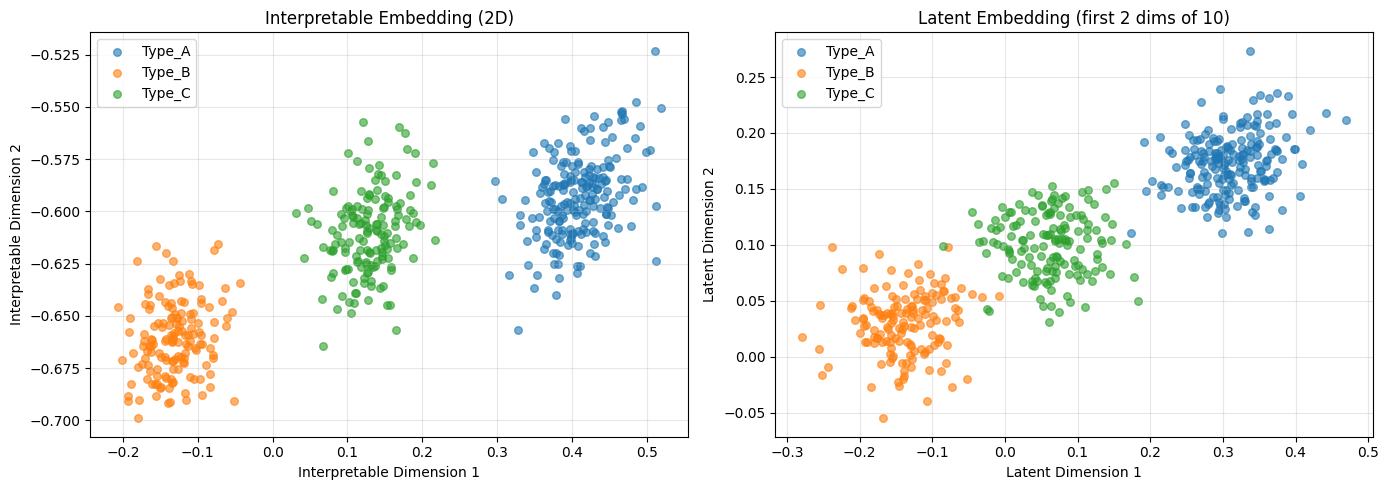


✅ LiVAE successfully separated the three cell types!


In [15]:
# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot interpretable embedding (2D)
for cell_type in ['Type_A', 'Type_B', 'Type_C']:
    mask = adata.obs['cell_type'] == cell_type
    axes[0].scatter(
        interpretable[mask, 0], 
        interpretable[mask, 1],
        label=cell_type,
        alpha=0.6,
        s=30
    )
axes[0].set_xlabel('Interpretable Dimension 1')
axes[0].set_ylabel('Interpretable Dimension 2')
axes[0].set_title('Interpretable Embedding (2D)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot first 2 dimensions of latent embedding
for cell_type in ['Type_A', 'Type_B', 'Type_C']:
    mask = adata.obs['cell_type'] == cell_type
    axes[1].scatter(
        latent[mask, 0], 
        latent[mask, 1],
        label=cell_type,
        alpha=0.6,
        s=30
    )
axes[1].set_xlabel('Latent Dimension 1')
axes[1].set_ylabel('Latent Dimension 2')
axes[1].set_title('Latent Embedding (first 2 dims of 10)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ LiVAE successfully separated the three cell types!")

## 8. Evaluate Clustering Quality

Finally, we quantify how well the learned embeddings capture the true cell type structure using standard clustering metrics on both the latent and interpretable embeddings.

In [16]:
# Perform clustering on latent representation
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Cluster using latent embedding
kmeans = KMeans(n_clusters=3, random_state=42)
predicted_labels = kmeans.fit_predict(latent)

# Convert true labels to numeric
label_map = {'Type_A': 0, 'Type_B': 1, 'Type_C': 2}
true_labels = adata.obs['cell_type'].map(label_map).values

# Calculate metrics
ari = adjusted_rand_score(true_labels, predicted_labels)
nmi = normalized_mutual_info_score(true_labels, predicted_labels)

print(f"\nClustering Performance:")
print(f"  Adjusted Rand Index (ARI): {ari:.3f}")
print(f"  Normalized Mutual Info (NMI): {nmi:.3f}")
print(f"\n  ARI = 1.0 means perfect clustering")
print(f"  ARI = 0.0 means random clustering")


Clustering Performance:
  Adjusted Rand Index (ARI): 1.000
  Normalized Mutual Info (NMI): 1.000

  ARI = 1.0 means perfect clustering
  ARI = 0.0 means random clustering
